In [1]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import shapely.wkt
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
# import local python modules
# import constants_sf as c
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

,XLongitude,YLatitude,ShapeID,FIPS,NAME,Area_sqmi,PortID,ShapeType,ACTIVITYKW,TYPE,geometry,STATE
0,-176.560565,51.996732,15630,02016,"Adak Island, AK",0.196221,None,Land-based,1.051860e+06,Land,"POLYGON ((-176.56532 51.99902, -176.56506 51.9...",AK
1,-152.112205,58.148559,15631,02150,"Afognak Bay, AK",0.196221,None,Land-based,7.016603e+05,Land,"POLYGON ((-152.11621 58.15151, -152.11585 58.1...",AK
2,-165.913068,54.211260,15632,02013,"Akutan Island, AK",0.196221,None,Land-based,1.979962e+08,Land,"POLYGON ((-165.91752 54.21386, -165.91722 54.2...",AK
3,-97.137111,27.901262,10382,48409,"Aransas Pass, TX",0.196221,None,Land-based,5.742776e+05,Land,"POLYGON ((-97.13717 27.90489, -97.13690 27.904...",TX
4,-88.988335,30.412697,10383,28047,"Back Bay of Biloxi, MS",0.196221,None,Land-based,1.320707e+04,Land,"POLYGON ((-88.98800 30.41631, -88.98772 30.416...",MS


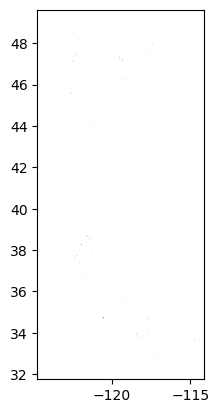

In [4]:
# load port location data
port_loc_dir = 'RawData/Port/Location/Ports_2014NEI.shp'
airport_loc_dir = 'RawData/Port/Location/airport_area.shp'
port_list_dir = 'RawData/Port/port_code_cbp.csv'
border_entry_dir = 'RawData/Port/Location/border_entry.txt'
# filter by location
selected_states = ['California', 'Washington', 'Oregon']
selected_fips = ['CA', 'WA', 'OR']
#sea and land
port_location = gpd.read_file(port_loc_dir)
port_location.loc[port_location['NAME'] == 'Carquinez', 'TYPE'] = 'Land'
port_location = \
port_location.loc[port_location['TYPE'] == 'Land']
port_location.loc[:, 'STATE'] = \
port_location.loc[:, 'NAME'].str.split(', ').str[1]
# port_location = \
# port_location.loc[port_location['STATE'].isin(selected_fips)]
port_location = port_location.to_crs('4326')

airport_location = gpd.read_file(airport_loc_dir)
airport_location = \
airport_location.loc[airport_location['STATE'].isin(selected_states)]
airport_location = airport_location.to_crs('4326')
airport_location.plot()

f = open(border_entry_dir,'r')
border_entry = f.readlines()
f.close()
list_of_ports = read_csv(port_list_dir)
port_location.head(5)

In [6]:
print(border_entry[0:5])

['Little Gold Creek\t Hwy 9\n', '(Top of the World Highway)\n', '\n', 'Yukon\tPoker Creek\tPKC\t AK-5 (Top of the World Highway)\tAlaska\tJune 1–Sept 1 (Canada) or day after Labor Day (US) (9:00–19:00 PT / 8:00–18:00 AKT), depending on weather & road conditions.\tNorthernmost Canada-U.S. border crossing\t64°5′8.02″N 141°0′3.92″W\n', 'Beaver Creek\t Hwy 1\n']


In [10]:
print(len(list_of_ports))
list_of_ports.loc[:, 'NAME'] = \
list_of_ports.loc[:, 'CBP Port Location'].str.split('(').str[0]

list_of_ports.loc[:, 'STATE'] = list_of_ports.loc[:, 'NAME'].str.split(',').str[1]
list_of_ports.loc[:, 'STATE'] = list_of_ports.loc[:, 'STATE'].str.replace(" ", "")
list_of_ports = list_of_ports.loc[list_of_ports['STATE'].isin(selected_fips)]


list_of_airports = \
list_of_ports.loc[list_of_ports['is_airport'] == 1]
print('numbers of airports in selected region:')
print(len(list_of_airports))

list_of_other_ports = \
list_of_ports.loc[list_of_ports['is_airport'] == 0]
print('numbers of other ports in selected region:')
print(len(list_of_other_ports))

list_of_ports.head(5)

50
numbers of airports in selected region:
9
numbers of other ports in selected region:
39


,Export Port Code,CBP Port Location,is_airport,Vessel,Air,Rail,Road,Fixed,NAME,STATE
0,2801,"San Francisco International Airport, CA (Port)",1,N,Y,N,N,N,"San Francisco International Airport, CA",CA
1,2802,"Eureka, CA (Port)",0,Y,N,N,N,N,"Eureka, CA",CA
2,2803,"Fresno, CA (Port)",1,Y,Y,N,N,N,"Fresno, CA",CA
3,2805,"Monterey, CA (Port)",0,Y,N,N,N,N,"Monterey, CA",CA
4,2809,"San Francisco, CA (Port)",0,Y,N,N,N,N,"San Francisco, CA",CA


In [11]:
list_of_ports.loc[:, 'STATE'].unique()

array(['CA', 'OR', 'WA'], dtype=object)

San Francisco International Airport, CA 
san francisco intl 86
Fresno, CA 
fresno air terminal 86
San Jose International Airport, CA 
san jose international 90
Sacramento International Airport, CA 
sacramento metropolitan 86
Portland International Airport, OR 
find the match!
portland intl 86
Friday Harbor, WA 
friday harbor 95
Spokane, WA 
spokane intl 78
Seattle-Tacoma International Airport, WA 
seattle-tacoma intl 86
Grant County Airport, WA 
grant county 90


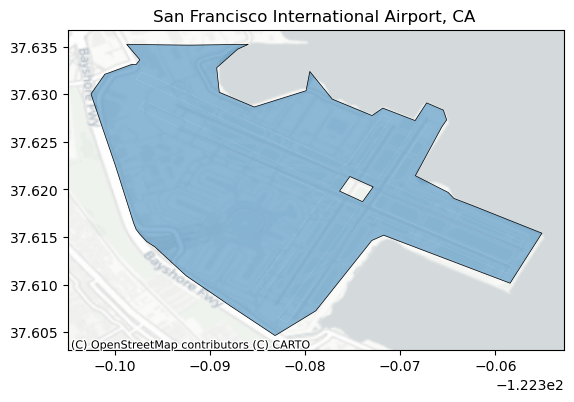

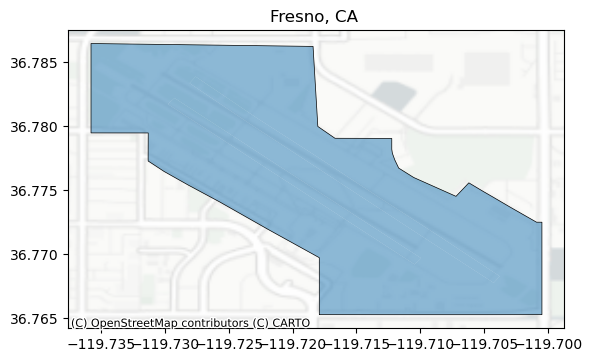

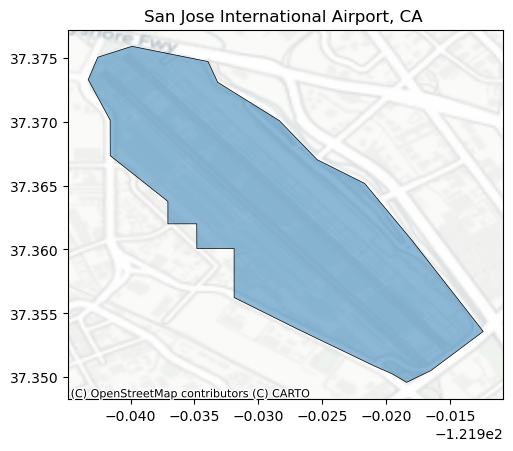

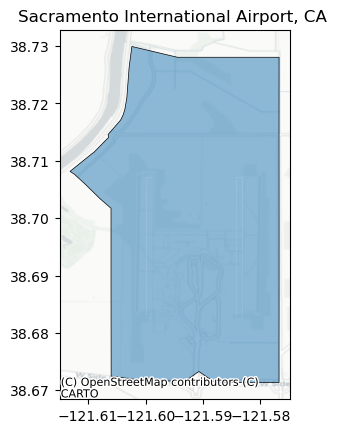

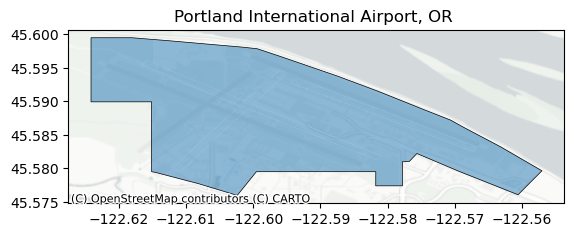

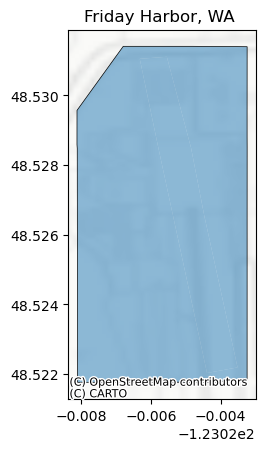

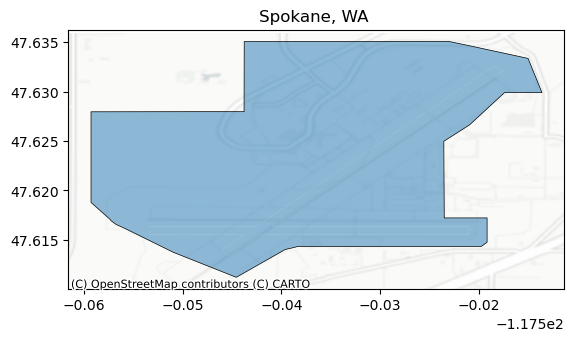

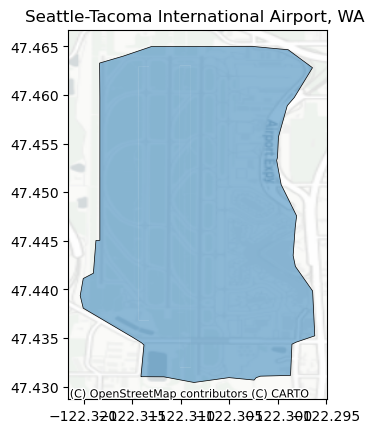

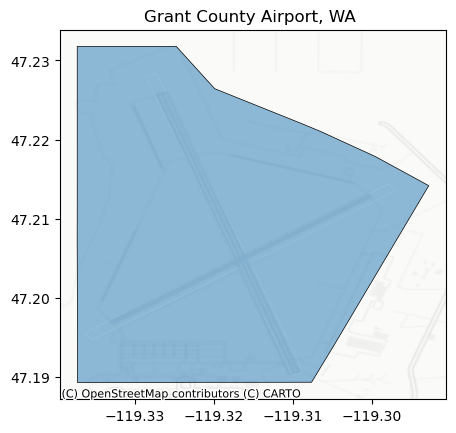

In [19]:
# match airport
# import difflib
list_of_airports.head(5)
airport_names = list_of_airports.NAME.unique()
# airport_names = lower(airport_names)
output_airport_gdf = None
matched_port = []
airport_location['NAME'] = airport_location['NAME'].str.lower()
for airport in airport_names:
    print(airport)
    airport_loc = \
    process.extract(airport, airport_location['NAME'], limit=1)[0][0]
    airport_score = \
    process.extract(airport, airport_location['NAME'], limit=1)[0][1]

    # manually match some:
    if airport == 'Portland International Airport, OR ':
        print('find the match!')
        airport_loc = 'portland intl'
    print(airport_loc, airport_score)
    airport_location_sel = \
    airport_location.loc[airport_location['NAME'] == airport_loc]
    airport_location_dissolved = airport_location_sel.dissolve()
    # airport_location_to_plot = airport_location_sel.buffer(0.5)
    ax = airport_location_sel.plot(alpha = 0.5)
    airport_location_dissolved.plot(ax = ax, facecolor='none', 
                              edgecolor='k',linewidth = 0.5)
    cx.add_basemap(ax, crs = 'EPSG:4236', 
                   source = cx.providers.CartoDB.Positron, zoom = 13)
    plt.title(airport)
    plt.savefig('RawData/Port/Plot/' + airport_loc + '_loc.png')
    airport_location_dissolved.loc[:, 'PORTID'] = airport
    airport_location_dissolved = \
    airport_location_dissolved[['NAME', 'STATE', 'geometry', 'PORTID']]
    output_airport_gdf = \
    pd.concat([output_airport_gdf, airport_location_dissolved])
    matched_port.append(airport)
    # break
# airport_location_dissolved

Eureka, CA 
eureka 90
Monterey, CA 
monterey 90
San Francisco, CA 
san francisco 95
Stockton, CA 
stockton 90
Oakland, CA 
oakland 90
Richmond, CA 
richmond, va 92
Martinez, CA 
martinez, ca 100
Redwood City, CA 
redwood city, ca 100
Selby, CA 
san pablo bay, ca 86
San Joaquin River, CA 
stockton 86
San Pablo Bay, CA 
san pablo bay, ca 100
Carquinez Strait, CA 
carquinez 90
Astoria, OR 
astoria 90
Newport, OR 
newport 90
Coos Bay, OR 
coos bay 90
Portland, OR 
portland, or 100
Longview, WA 
longview, wa 100
Vancouver, WA 
vancouver 95
Kalama, WA 
kalama 90
Seattle, WA 
seattle 90
Tacoma, WA 
tacoma 90
Aberdeen-Hoquiam, WA 
blaine, wa 86
Blaine, WA 
blaine, wa 100
Bellingham, WA 
bellingham, wa 100
Everett, WA 
everett 90
Port Angeles, WA 
port angeles 95
Port Townsend, WA 
port townsend, wa 100
Sumas, WA 
do not process Sumas, WA 
Anacortes, WA 
anacortes 95
Danville, WA 
do not process Danville, WA 
Ferry, WA 
do not process Ferry, WA 
Boundary, WA 
do not process Boundary, WA 
Laurie

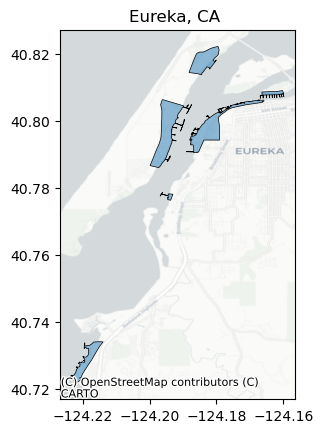

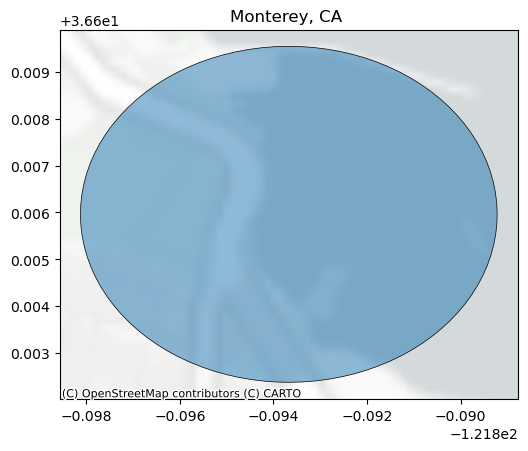

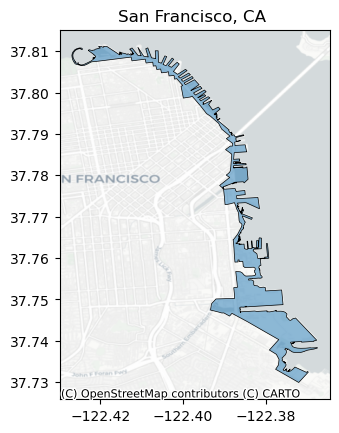

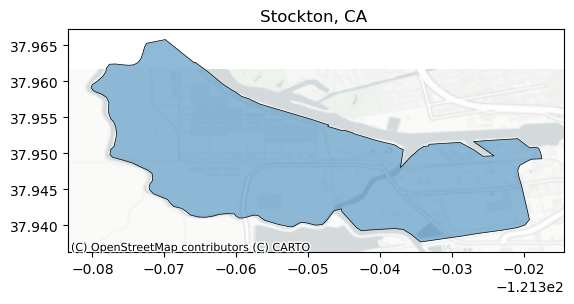

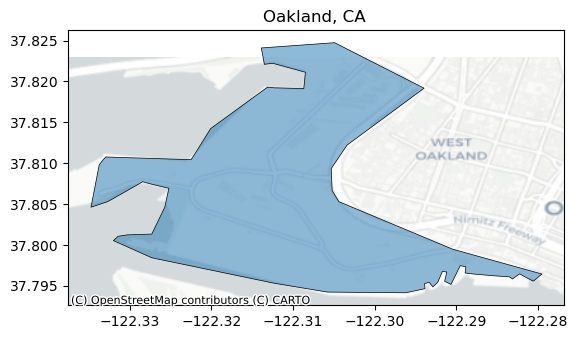

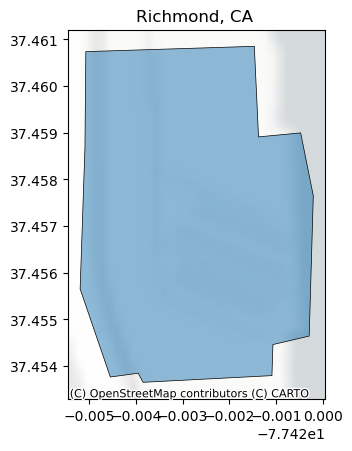

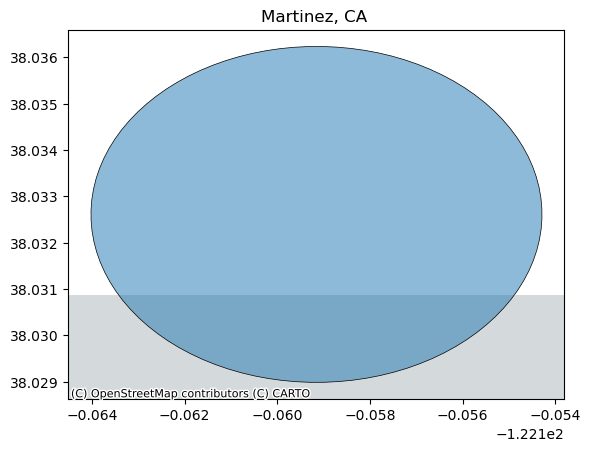

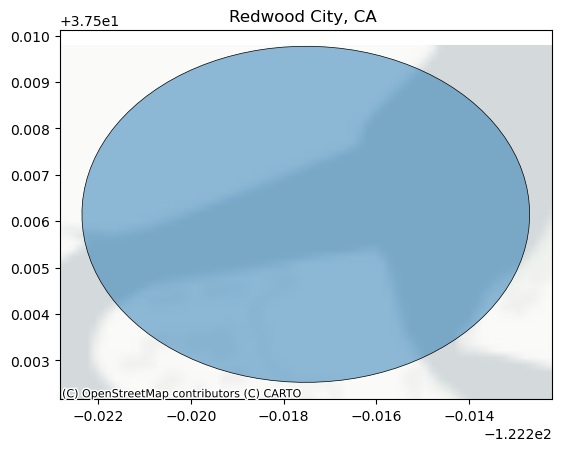

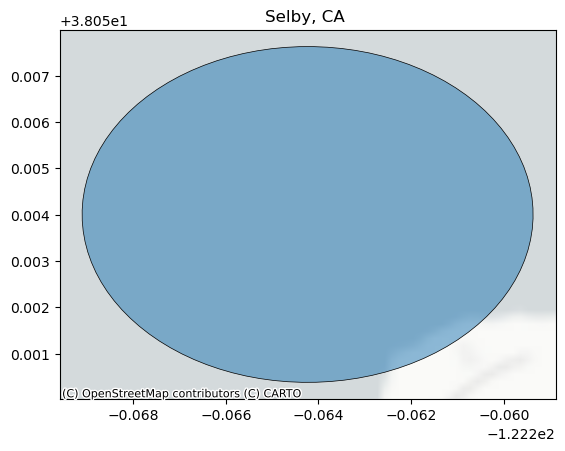

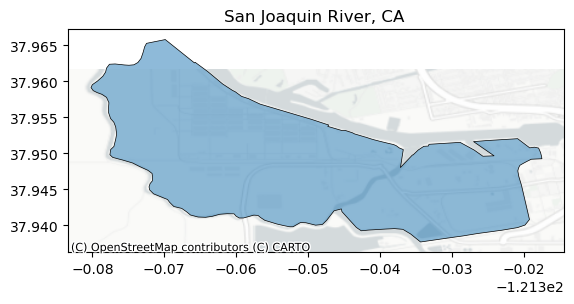

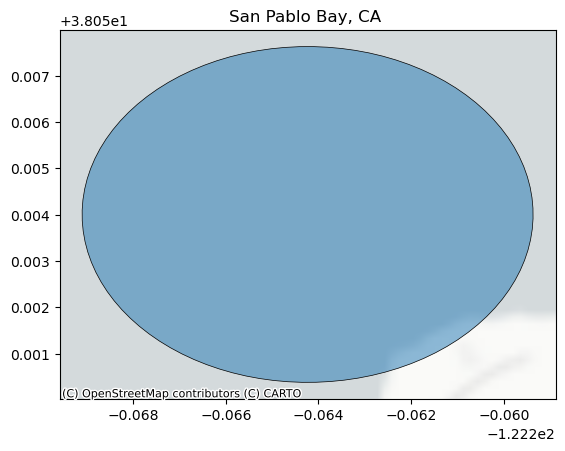

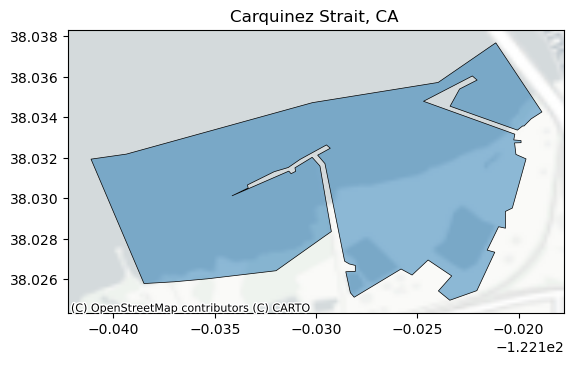

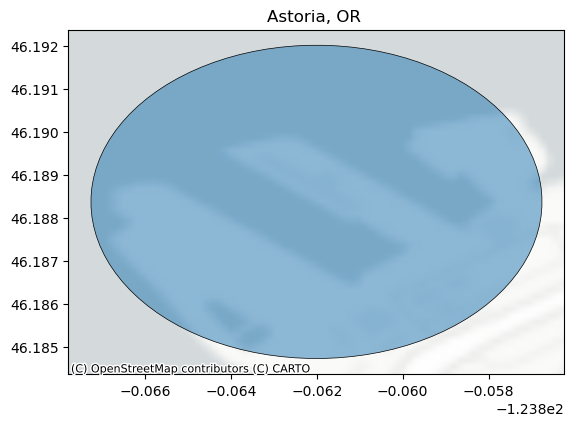

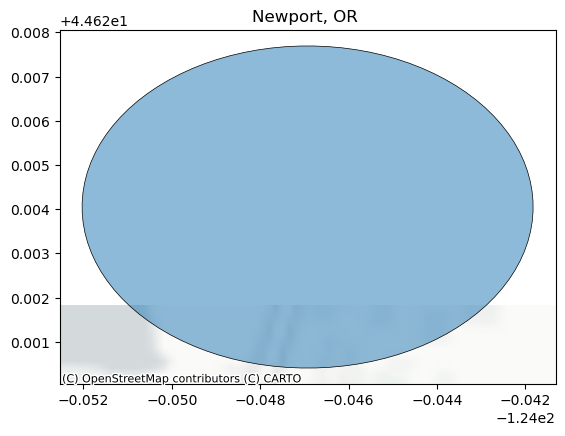

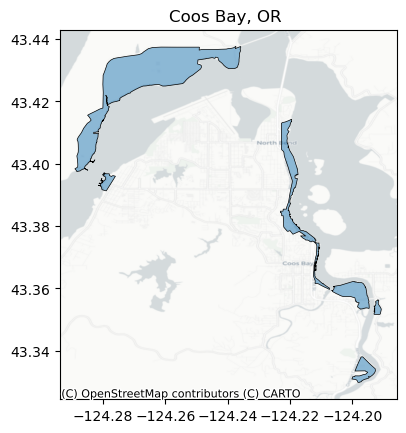

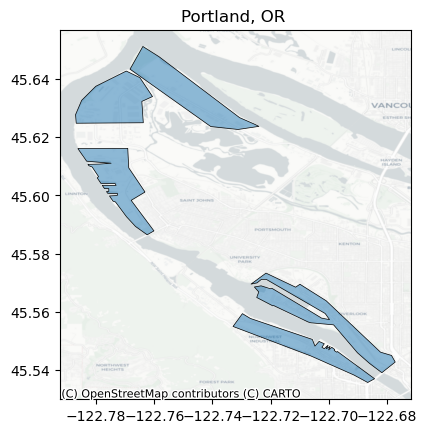

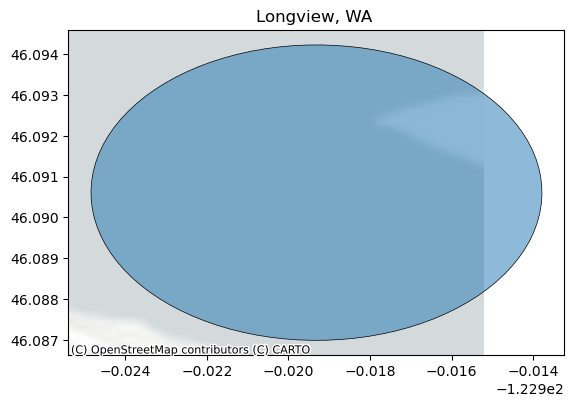

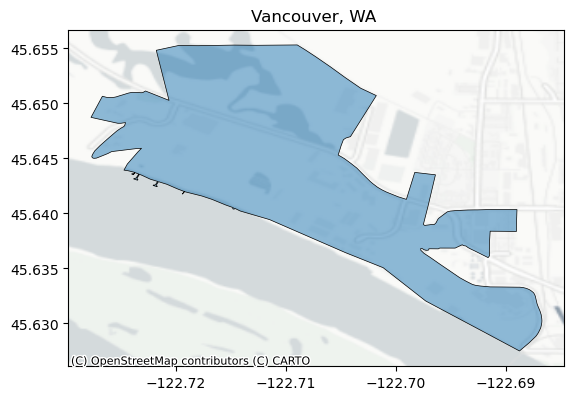

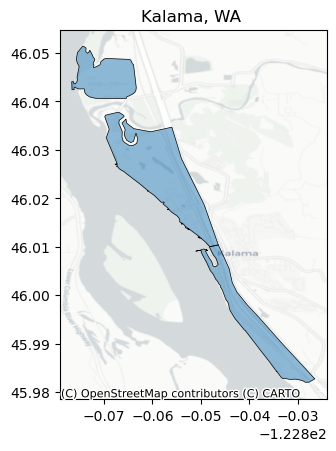

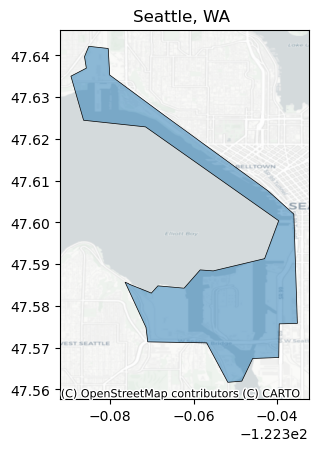

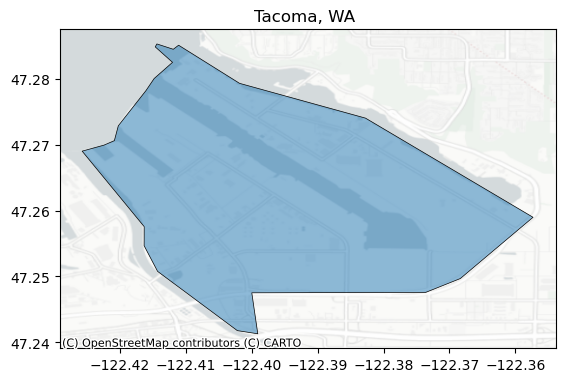

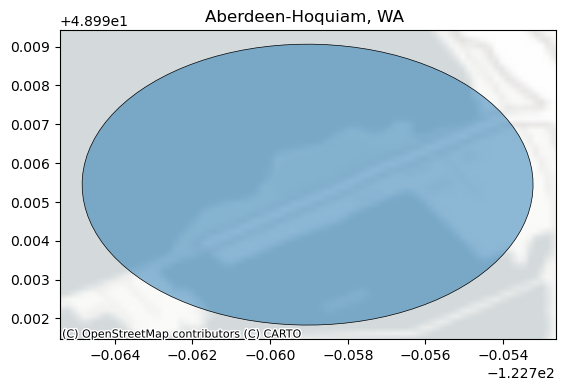

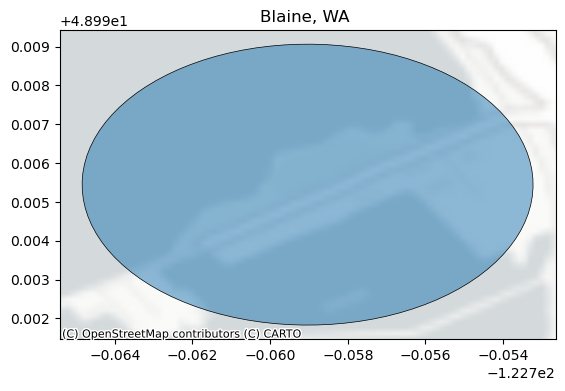

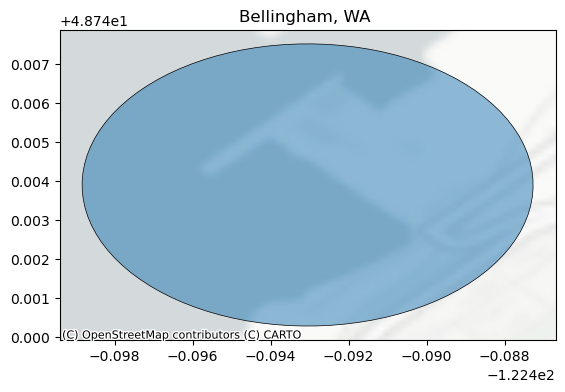

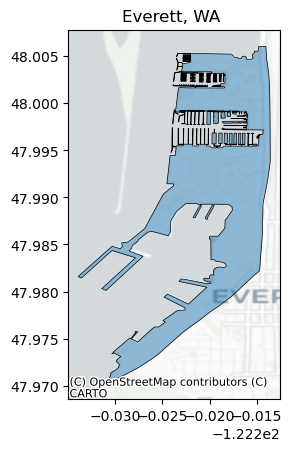

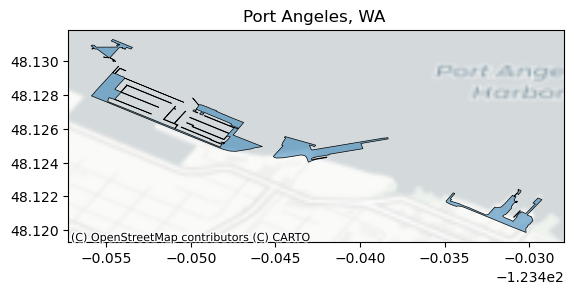

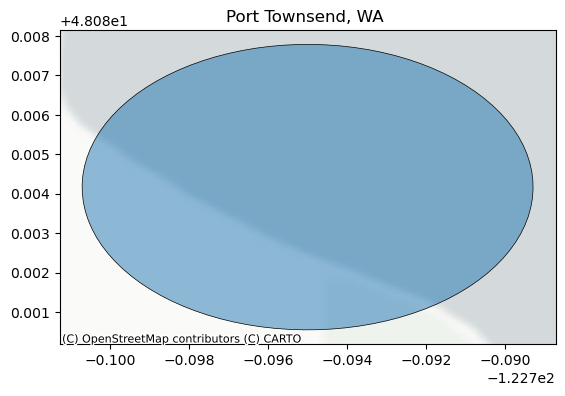

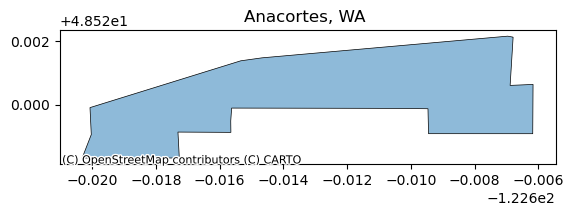

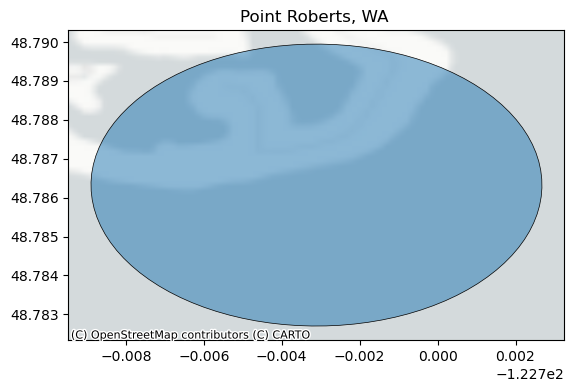

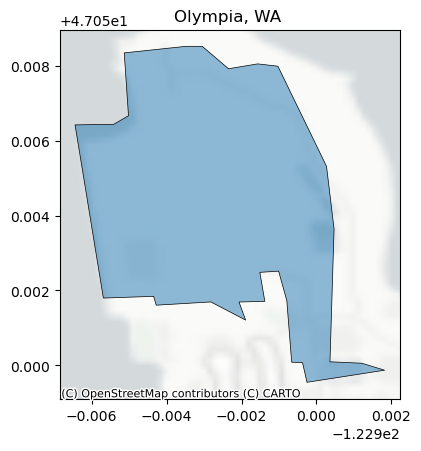

In [20]:
# match other ports
# import difflib

otherport_names = list_of_other_ports.NAME.unique()
# airport_names = lower(airport_names)
output_port_gdf = None
# matched_port = []

port_location['NAME'] = port_location['NAME'].str.lower()
port_location = \
port_location.loc[port_location['NAME'] != 'other ports l.a. district, ca']
port_location = \
port_location.loc[port_location['FIPS'] != '44005']
canadian_border = ['Sumas, WA ', # yes
                   'Danville, WA ', # yes
                   'Ferry, WA ',
                'Boundary, WA ', 'Laurier, WA ', 'Oroville, WA ',
                'Frontier, WA ', 'Lynden, WA ', 'Metaline Falls, WA ']
for port in otherport_names:
    print(port)
    port_loc = \
    process.extract(port, port_location['NAME'], limit=1)[0][0]
    port_score = \
    process.extract(port, port_location['NAME'], limit=1)[0][1]

    # manually match some:
    if port == 'Monterey, CA ':
        # print('find the match!')
        port_loc = 'monterey'
    if port == 'Selby, CA ':
        port_loc = 'san pablo bay, ca'
    if port == 'San Joaquin River, CA ':
        port_loc = 'stockton'
    if port == 'Carquinez Strait, CA ':
        port_loc = 'carquinez'
    if port == 'Aberdeen-Hoquiam, WA':
        port_loc = 'grays harbor'
    if port in canadian_border:
        print('do not process '  + port)
        continue
    print(port_loc, port_score)
    port_location_sel = \
    port_location.loc[port_location['NAME'] == port_loc]
    port_location_dissolved = port_location_sel.dissolve()
    # airport_location_to_plot = airport_location_sel.buffer(0.5)
    ax = port_location_sel.plot(alpha = 0.5)
    port_location_dissolved.plot(ax = ax, facecolor='none', 
                              edgecolor='k',linewidth = 0.5)
    cx.add_basemap(ax, crs = 'EPSG:4236', 
                   source = cx.providers.CartoDB.Positron, zoom = 13)
    plt.title(port)
    plt.savefig('RawData/Port/Plot/' + port_loc + '_loc.png')
    port_location_dissolved.loc[:, 'PORTID'] = airport
    port_location_dissolved = \
    port_location_dissolved[['NAME', 'STATE', 'geometry', 'PORTID']]
    output_port_gdf = \
    pd.concat([output_port_gdf, port_location_dissolved])
    matched_port.append(port)
    

In [10]:
port_location['NAME'].unique()[0:10]

array(['adak island, ak', 'afognak bay, ak', 'akutan island, ak',
       'aransas pass, tx', 'back bay of biloxi, ms', 'bar harbor, me',
       'baralof bay, ak', 'barataria bay waterway, la', 'bath, me',
       'bayou la batre, al'], dtype=object)

In [12]:
# process Sumas, WA, Danville, WA, 'Ferry, WA', Boundary, WA,  'Laurier, WA'

array(['41041', '44005'], dtype=object)